# Metoda gradientów sprzężonych Polaka-Ribiere'a

Projekt nr 2 z przedmiotu Optymalizacja Nieliniowa.
Autor: Vitalii Morskyi

## Podstawa teoretyczna

Metoda gradientów sprzężonych: 

$$ d^{(0)} = -\nabla f(x^{(0)}) $$
$$ d^{(i+1)} = -\nabla f(x^{(i+1)}) + \beta^{(i+1)}d^{(i)} $$

gdzie w metodzie Polaka-Ribiere'a:
$$ \beta^{(i+1)} = \frac{\nabla f(x^{(i+1)})^T \left( \nabla f(x^{(i+1)}) - \nabla f(x^{(i)}) \right)}{\nabla f(x^{(i)})^T\nabla f(x^{(i)})} $$

Algorytm obliczania wartości minimalnej podany jest w następujący sposób: 
![Polak-Ribiere alogrithm](../media/polak_ribiere_method.png)

[(źródło)](https://indrag49.github.io/Numerical-Optimization/conjugate-gradient-methods-1.html#polak-ribiere-algorithm)

## Zadanie projektowe

Firma produkuje pomidory i paprykę i sprzedaje je po cenie 5 zł za kilogram pomidorów i 8 zł za kilogram papryki. Koszt produkcji $x$ kg pomidorów i $y$ kg papryki wynosi $C(x, y) = x^2 + 0.9xy\sin(x)\sin(y) + y^2$. Przychód ze sprzedaży $x$ kg pomidorów i $y$ kg papryki wynosi $R(x, y) = 5x + 8y$, a zysk to $P(x, y) = R(x, y) − C(x, y)$. Ile pomidorów i papryki powinna wyprodukować firma, aby uzyskać maksymalny zysk? ([źródło](http://newb.kettering.edu/wp/experientialcalculus/wp-content/uploads/sites/15/2017/05/Module_II.pdf))

## Rozwiązanie

Funkcja, którą trzeba zmaksymalizować:

$$ P(x,y) = R(x,y)-C(x,y) = 5x+8y - x^2 - 0.9xy\sin(x)\sin(y) - y^2 $$

Możemy zapisać ją ze znakiem przeciwnym, wtedy otrzymamy problem minimalizacji: 

$$ f(x,y) = x^2 + 0.9xy\sin(x)\sin(y) + y^2 - 5x - 8y $$

In [1]:
# Importowanie niezbędnych modułów
import numpy as np
import autograd.numpy as anp
from autograd import grad
from scipy.optimize import line_search
import plotly.graph_objects as go


In [2]:
def f(x):
    """Funkcja celu"""
    # return x[0] ** 2 + 3 * x[0] * x[1] + x[1] ** 2 - 2 * x[0] - 3 * x[1]
    return x[0] ** 2 + 0.9 * anp.sin(x[0]) * anp.sin(x[1]) * x[0] * x[1] + x[1] ** 2 - 5 * x[0] - 8 * x[1]


# Gradient funkcji f
df = grad(f)


In [3]:
def polak_ribiere(func, grad_func, Xj, alpha_1=1e-4, alpha_2=2e-1, tol=1e-6):
    """Nieznacznie zmieniona wersja rozwiązania rozwiązania z tej strony: 
    https://indrag49.github.io/Numerical-Optimization/conjugate-gradient-methods-1.html
    """
    D = grad_func(Xj)
    delta = -D
    iteration = 0
    all_xs, all_ys, all_fs = [Xj[0]], [Xj[1]], [f(Xj)]
    while True:
        print(
            f"It {iteration}\t{Xj=}\t{f(Xj)=:.5f}\tgrad={np.linalg.norm(grad_func(Xj)):.5f}")
        beta = line_search(
            f=func,
            myfprime=grad_func,
            xk=Xj,
            pk=delta,
            c1=alpha_1,
            c2=alpha_2
        )[0]
        if beta is not None:
            X = Xj + beta * delta

        if np.linalg.norm(grad_func(X)) < tol:
            return X, func(X), all_xs, all_ys, all_fs
        else:
            Xj = X
            d = D
            D = grad_func(Xj)
            chi = (D-d).dot(D)/(np.linalg.norm(d) ** 2)
            chi = max(0, chi)
            delta = -D + chi * delta
            
        all_xs += [Xj[0], ]
        all_ys += [Xj[1], ]
        all_fs += [f(Xj), ]
        iteration += 1


In [4]:
X_sol, f_sol, all_xs, all_ys, all_fs = polak_ribiere(f, df, np.array([10., 10.]))
X_sol


It 0	Xj=array([10., 10.])	f(Xj)=96.63631	grad=80.98609
It 1	Xj=array([1.62611674, 2.05374719])	f(Xj)=-15.04059	grad=4.00054
It 2	Xj=array([0.72443083, 2.87537363])	f(Xj)=-17.50572	grad=4.30965
It 3	Xj=array([1.83960084, 4.86790369])	f(Xj)=-28.73692	grad=3.64332
It 4	Xj=array([2.04870497, 4.88800962])	f(Xj)=-29.13756	grad=1.69882
It 5	Xj=array([2.11057808, 4.74318893])	f(Xj)=-29.27114	grad=0.21215
It 6	Xj=array([2.09642389, 4.73492878])	f(Xj)=-29.27284	grad=0.01652
It 7	Xj=array([2.09699742, 4.73352564])	f(Xj)=-29.27285	grad=0.00340
It 8	Xj=array([2.09723026, 4.73362203])	f(Xj)=-29.27285	grad=0.00035


array([2.0972204, 4.733655 ])

In [5]:
def plot_sol(x_path, y_path, f_path):
    meshgrid = xs, ys = np.mgrid[-5:15:0.1, -5:15:0.1]
    z_data = np.array(list(map(f, meshgrid.T.reshape(40000, 2)))
                    ).reshape(200, 200).T
    fig = go.Figure(data=[go.Surface(x=xs, y=ys, z=z_data)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                    highlightcolor="limegreen", project_z=True))
    fig.add_trace(go.Scatter3d(
            x=x_path, y=y_path, z=f_path,
            marker=dict(
                size=3,
            ),
            line=dict(
                color='white',
                width=2
            )
        ))
    fig.update_layout(title='Wykres funkcji celu', autosize=True,
                    scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                    # width=1000, height=1000,
                    margin=dict(l=65, r=50, b=65, t=90)
                    )

    fig.show()


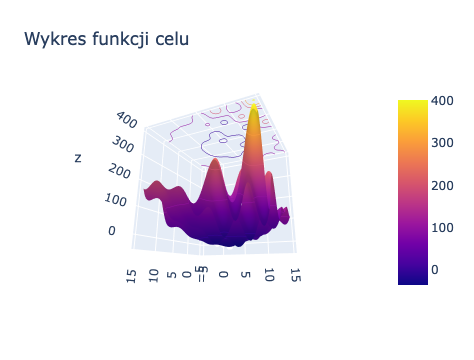

In [6]:
plot_sol(all_xs, all_ys, all_fs)

It 0	Xj=array([5., 8.])	f(Xj)=-34.15391	grad=12.04400
It 1	Xj=array([4.74794862, 7.73328624])	f(Xj)=-36.04368	grad=1.45106
It 2	Xj=array([4.74794862, 7.73328624])	f(Xj)=-36.04368	grad=1.45106
It 3	Xj=array([4.78213154, 7.75388959])	f(Xj)=-36.07455	grad=0.10293
It 4	Xj=array([4.78355873, 7.7565612 ])	f(Xj)=-36.07470	grad=0.00071
It 5	Xj=array([4.78355168, 7.75658023])	f(Xj)=-36.07470	grad=0.00003


/Users/vmorskyi/miniconda3/envs/on-project/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge



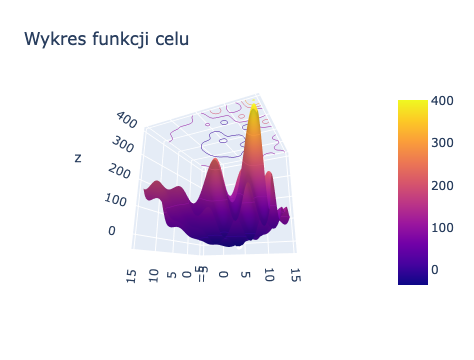

In [11]:
X_sol, f_sol, all_xs, all_ys, all_fs = polak_ribiere(f, df, np.array([5., 8.]))
plot_sol(all_xs, all_ys, all_fs)

It 0	Xj=array([7.5, 4.8])	f(Xj)=-26.88464	grad=5.61160
It 1	Xj=array([7.65180985, 4.85950953])	f(Xj)=-27.39998	grad=0.60049
It 2	Xj=array([7.66912124, 4.86393244])	f(Xj)=-27.40548	grad=0.01575
It 3	Xj=array([7.66958578, 4.86384824])	f(Xj)=-27.40549	grad=0.00054
It 4	Xj=array([7.66958896, 4.86386287])	f(Xj)=-27.40549	grad=0.00001


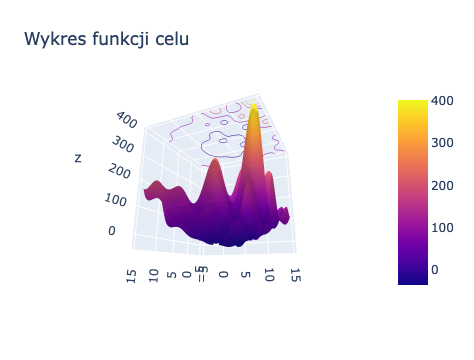

In [10]:
X_sol, f_sol, all_xs, all_ys, all_fs = polak_ribiere(f, df, np.array([7.5, 4.8]))
plot_sol(all_xs, all_ys, all_fs)